In [1]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

In [2]:
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([4., 0., 0., 3., 0., 0., 2., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

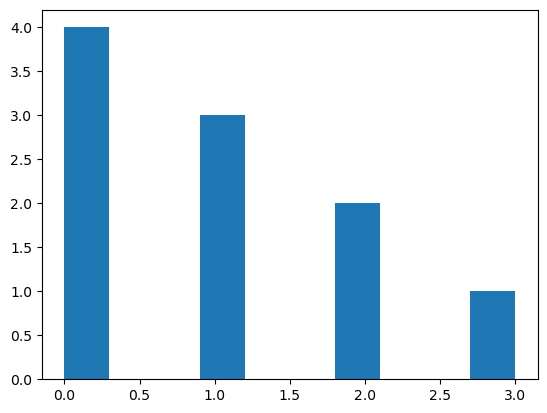

In [3]:
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([434., 296., 162.,  68.,  27.,  13.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

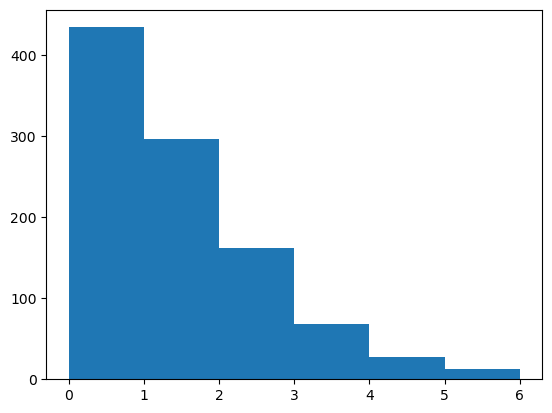

In [4]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [5]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

In [6]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [7]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

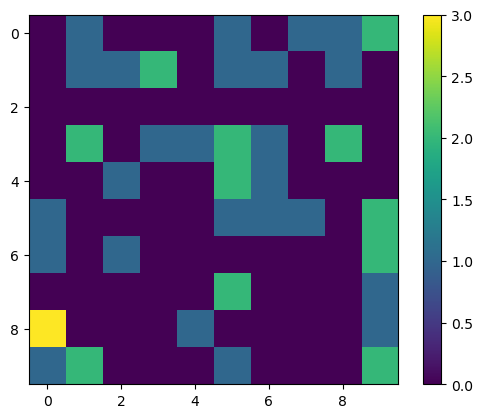

In [8]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

In [9]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [10]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

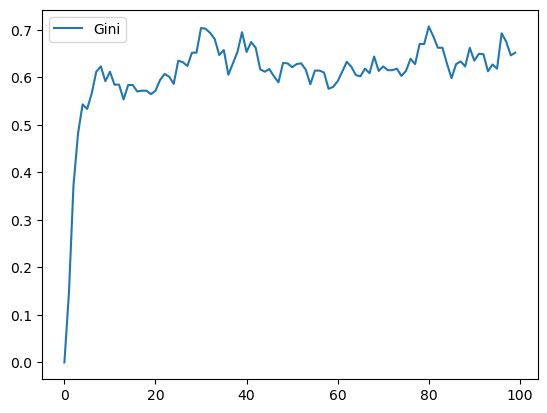

In [11]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot();

In [12]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

In [13]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth

AgentID
0     1
1     1
2     0
3     1
4     0
5     1
6     0
7     0
8     0
9     0
10    1
11    7
12    0
13    1
14    0
15    1
16    1
17    0
18    1
19    0
20    0
21    0
22    1
23    0
24    0
25    2
26    0
27    1
28    0
29    5
30    1
31    1
32    2
33    1
34    0
35    9
36    1
37    1
38    0
39    0
40    1
41    1
42    0
43    0
44    2
45    1
46    2
47    0
48    1
49    1
Name: Wealth, dtype: int64

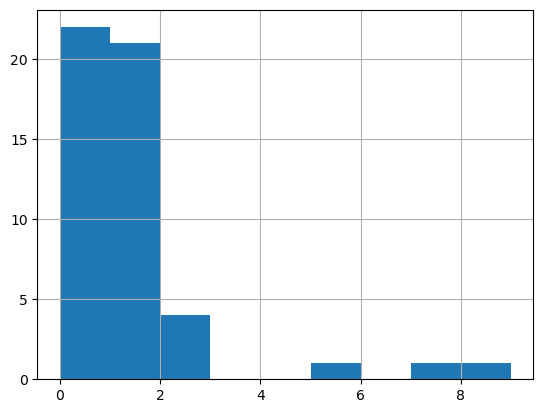

In [14]:
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1));

<AxesSubplot: xlabel='Step'>

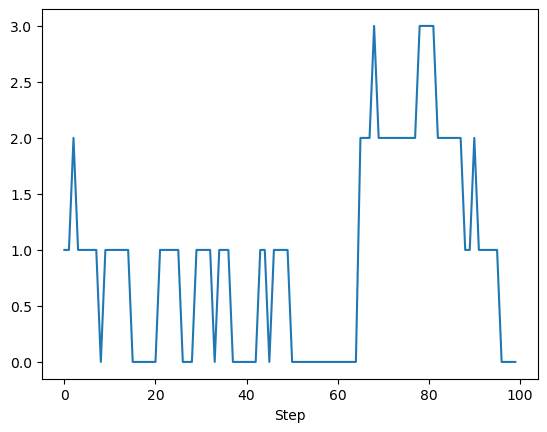

In [15]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [16]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [17]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 245/245 [01:11<00:00,  3.45it/s]


In [18]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


In [19]:
results_df

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth
0,0,0,0,10,10,10,0.000000,0,1
1,0,0,0,10,10,10,0.000000,1,1
2,0,0,0,10,10,10,0.000000,2,1
3,0,0,0,10,10,10,0.000000,3,1
4,0,0,0,10,10,10,0.000000,4,1
...,...,...,...,...,...,...,...,...,...
6186245,244,4,100,10,10,490,0.630329,485,3
6186246,244,4,100,10,10,490,0.630329,486,0
6186247,244,4,100,10,10,490,0.630329,487,1
6186248,244,4,100,10,10,490,0.630329,488,2


In [35]:
results_df[(results_df.iteration==0) & (results_df.Step==0)]

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth
0,0,0,0,10,10,10,0.0,0,1
1,0,0,0,10,10,10,0.0,1,1
2,0,0,0,10,10,10,0.0,2,1
3,0,0,0,10,10,10,0.0,3,1
4,0,0,0,10,10,10,0.0,4,1
...,...,...,...,...,...,...,...,...,...
1188245,48,0,0,10,10,490,0.0,485,1
1188246,48,0,0,10,10,490,0.0,486,1
1188247,48,0,0,10,10,490,0.0,487,1
1188248,48,0,0,10,10,490,0.0,488,1


In [36]:
import mesa
def agent_portrayal(agent):
    portrayal = {
        "Shape": "circle",
        "Color": "red",
        "Filled": "true",
        "Layer": 0,
        "r": 0.5,
    }
    return portrayal

In [40]:
"""
The full code should now look like:
"""
# from MoneyModel import *
import mesa


def agent_portrayal(agent):
    portrayal = {
        "Shape": "circle",
        "Filled": "true",
        "Layer": 0,
        "Color": "red",
        "r": 0.5,
    }
    return portrayal


grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = mesa.visualization.ModularServer(
    MoneyModel, [grid], "Money Model", {"N": 100, "width": 10, "height": 10}
)
server.port = 8521  # The default
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted

Socket opened!
{"type":"reset"}
Socket opened!
{"type":"reset"}


In [39]:
import mesa


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = mesa.visualization.ModularServer(
    MoneyModel, [grid], "Money Model", {"N": 100, "width": 10, "height": 10}
)
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [WinError 10048] Only one usage of each socket address (protocol/network address/port) is normally permitted